# Camp 1

[INFO][abstract_initial_design.py:95] Reducing the number of initial configurations from 40 to 25 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:147] Using 25 initial design configurations and 0 additional configurations.
[INFO][smbo.py:498] Continuing from previous run.
[INFO][smbo.py:506] Since the previous run was not successful, SMAC will start from scratch again.


C:\Users\mrram\AppData\Local\Temp\ipykernel_131888\1878619146.py:99: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_131888\1878619146.py:99: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_131888\1878619146.py:99: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_131888\1878619146.py:99: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_131888\1878619146.py:99: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Us

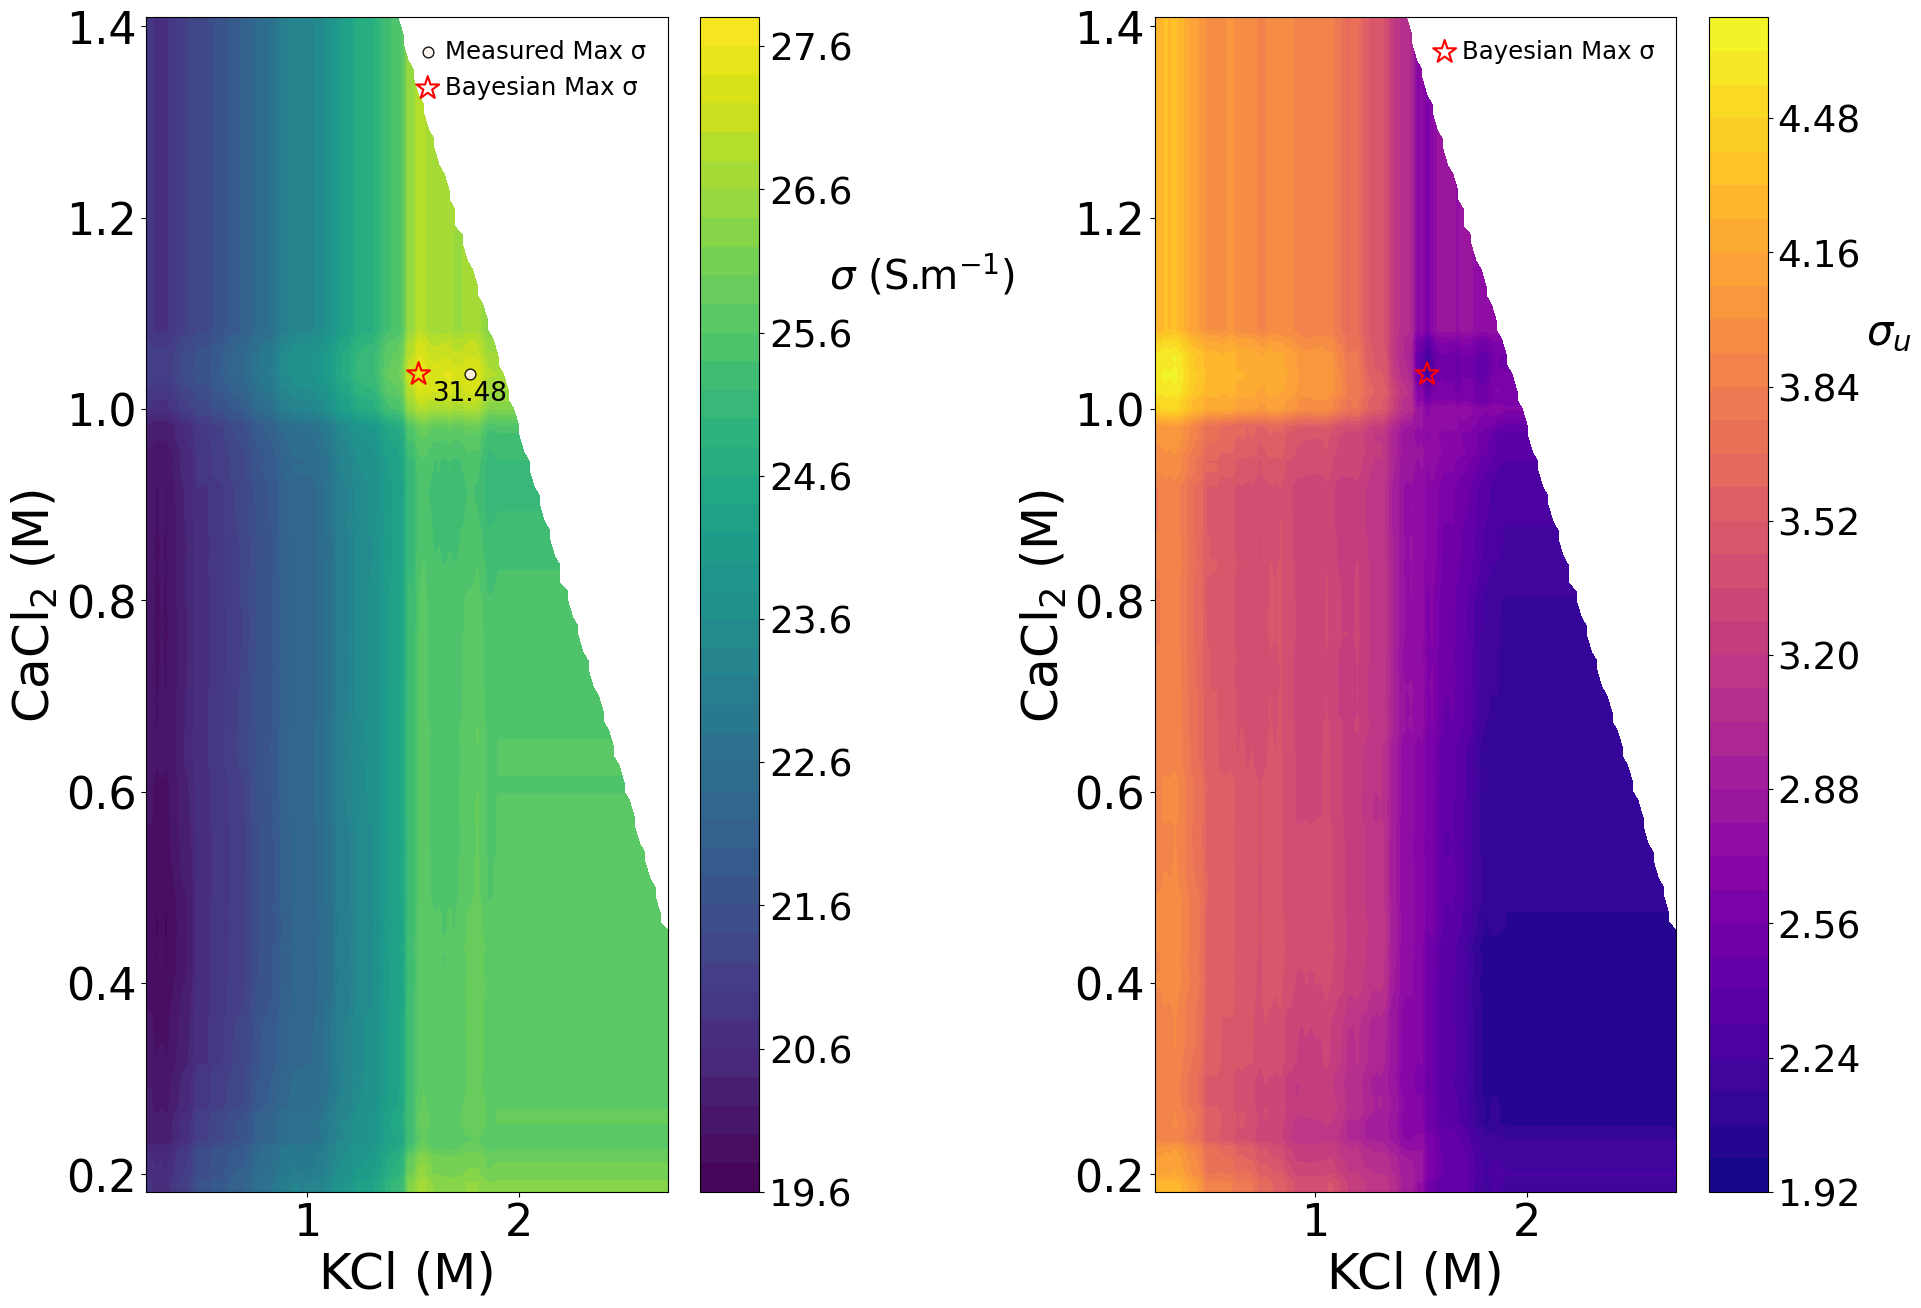

In [ ]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from ConfigSpace import ConfigurationSpace, UniformIntegerHyperparameter, Configuration
from smac import Scenario
from smac.facade.hyperparameter_optimization_facade import HyperparameterOptimizationFacade
from smac.model.random_forest.random_forest import RandomForest
from smac.runhistory.runhistory import RunHistory
from smac.runhistory.enumerations import StatusType
import matplotlib.ticker as ticker


def build_configspace(num_inputs: int, max_sum: int = 330):
    min_vals = [20] + [20]*(num_inputs-1)
    total_min = sum(min_vals)
    max_vals = [max_sum - (total_min - m) for m in min_vals]

    cs = ConfigurationSpace(seed=42)
    for i in range(num_inputs):
        cs.add(
            UniformIntegerHyperparameter(
                f"input_{i+1}",
                lower=min_vals[i],
                upper=max_vals[i],
            )
        )
    return cs

def csv_to_runhistory(csv_file: str, cs, obj_col: str = "objective_1", max_sum: int = 330):
    df = pd.read_csv(csv_file).dropna(subset=[obj_col])
    rh = RunHistory()
    for _, row in df.iterrows():
        cfg_vals = {k: int(row[k]) for k in row.index if re.match(r"input_\d+", k)}
        if sum(cfg_vals.values()) > max_sum:
            continue
        cost = -float(row[obj_col])
        rh.add(Configuration(cs, cfg_vals), cost=cost, time=0.0, status=StatusType.SUCCESS, seed=0)
    return rh

def train_rf(cs, rh, seed: int = 42):
    X = np.array([cfg.get_array() for cfg in rh.get_configs()])
    Y = np.array([rh.get_cost(cfg) for cfg in rh.get_configs()]).reshape(-1,1)
    rf = RandomForest(configspace=cs, n_trees=200, ratio_features=0.5, log_y=False, seed=seed)
    rf.train(X, Y)
    return rf, X, Y

# def parity_plot(model, X, Y):
#     mu, _ = model.predict_marginalized(X)
#     pred = -mu.reshape(-1)
#     true = -Y.reshape(-1)
#     plt.figure(figsize=(3.4, 2.8))  # single-column width
#     plt.scatter(true, pred, alpha=0.7, s=35)
#     lims = (min(true.min(), pred.min()), max(true.max(), pred.max()))
#     plt.plot(lims, lims, "k--", lw=1)
#     plt.xlabel(r"Measured $\sigma$ (S m$^{-1}$)", fontsize=11)
#     plt.ylabel(r"Predicted $\sigma$ (S m$^{-1}$)", fontsize=11)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.tight_layout()
#     plt.show()

def slice_2d(
    model,
    cs,
    fixed,
    axis_x,
    axis_y,
    grid_pts   = 100,
    max_sum    = 330,
    scale_x    = 1.0,
    scale_y    = 1.0
):
    ticksize   = 32
    labelsize  = 36
    legsize    = 27

    pretty_names = {
        "input_1": "NaCl",
        "input_2": "KCl (M)",
        "input_3": "MgCl$_2$",
        "input_4": "CaCl$_2$ (M)"
    }

    # 1 Read CSV
    df = pd.read_csv(csv_file)
    x_min_data = int(df[axis_x].min())
    x_max_data = int(df[axis_x].max())
    y_min_data = int(df[axis_y].min())
    y_max_data = int(df[axis_y].max())

    # 2 Grid over observed range
    xs = np.linspace(x_min_data, x_max_data, grid_pts, dtype=int)
    ys = np.linspace(y_min_data, y_max_data, grid_pts, dtype=int)

    Z_mu  = np.full((grid_pts, grid_pts), np.nan)
    Z_sig = np.full_like(Z_mu, np.nan)

    # 3 Predicct
    for i, xv in enumerate(xs):
        for j, yv in enumerate(ys):
            cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
            cfg_dict.update(fixed)
            cfg_dict[axis_x] = xv
            cfg_dict[axis_y] = yv

            if sum(cfg_dict.values()) > max_sum:
                continue

            arr = Configuration(cs, cfg_dict).get_array().reshape(1, -1)
            mu, var = model.predict_marginalized(arr)
            Z_mu[j, i]  = -mu.item()
            Z_sig[j, i] = np.sqrt(var.item())

    # 4 Meshgrid and scaling
    Xg, Yg = np.meshgrid(xs, ys)
    Xg_scaled = Xg * scale_x
    Yg_scaled = Yg * scale_y

    fig, ax = plt.subplots(1, 2, figsize=(19.2, 13.2))

    #  σ left plot
    c1 = ax[0].contourf(Xg_scaled, Yg_scaled, Z_mu, levels=40, cmap="viridis")
    cbar1 = fig.colorbar(c1, ax=ax[0])
    cbar1.set_label(r"$\sigma$ (S.m$^{-1}$)", rotation=0,
                    fontsize=legsize+2, labelpad=50)
    cbar1.ax.yaxis.label.set_position((-0.05, 0.8))
    cbar1.ax.tick_params(labelsize=legsize)

    ax[0].set_xlabel(pretty_names[axis_x], fontsize=labelsize)
    ax[0].set_ylabel(pretty_names[axis_y], fontsize=labelsize)
    ax[0].tick_params(labelsize=ticksize)

    slice_df = df[
        (df["input_1"] == fixed["input_1"]) &
        (df["input_3"] == fixed["input_3"])
    ]
    ax[0].scatter(
        slice_df[axis_x] * scale_x,
        slice_df[axis_y] * scale_y,
        c = slice_df["objective_1"],
        cmap = "Reds",
        edgecolors = "black",
        s = 60,
        alpha = 0.9,
        label = "Measured Max σ"
    )
    for _, row in slice_df.iterrows():
        ax[0].text(
            row[axis_x] * scale_x,
            row[axis_y] * scale_y - 0.02,
            f"{row['objective_1']:.2f}",
            color="black",
            fontsize=legsize*0.7,
            ha="center",
            va="center"
        )
    # ax[0].legend(loc="upper right", fontsize=legsize, frameon=False)

    ax[0].set_xlim(x_min_data * scale_x, x_max_data * scale_x)
    ax[0].set_ylim(y_min_data * scale_y, y_max_data * scale_y)

    # σ_u plot
    c2 = ax[1].contourf(Xg_scaled, Yg_scaled, Z_sig, levels=40, cmap="plasma")
    cbar2 = fig.colorbar(c2, ax=ax[1])
    cbar2.set_label(r"$\sigma_u$", rotation=0,
                    fontsize=legsize+3, labelpad=20)
    cbar2.ax.yaxis.label.set_position((-0.05, 0.75))
    cbar2.ax.tick_params(labelsize=legsize)

    ax[1].set_xlabel(pretty_names[axis_x], fontsize=labelsize)
    ax[1].set_ylabel(pretty_names[axis_y], fontsize=labelsize)
    ax[1].tick_params(labelsize=ticksize)
    ax[1].set_xlim(x_min_data * scale_x, x_max_data * scale_x)
    ax[1].set_ylim(y_min_data * scale_y, y_max_data * scale_y)

    # Mark RF max on both panels
    if np.isfinite(Z_mu).any():
        max_idx = np.unravel_index(np.nanargmax(Z_mu), Z_mu.shape)
        x_star  = Xg[max_idx] * scale_x
        y_star  = Yg[max_idx] * scale_y
        for axis in ax:
            axis.scatter(
                x_star, y_star,
                s=300, marker='*',
                facecolors='none', edgecolors='red',
                linewidths=1.5, label='Bayesian Max σ'
            )
        ax[0].legend(loc="upper right", fontsize=legsize*0.65, frameon=False, handletextpad=-0.3)
        ax[1].legend(loc="upper right", fontsize=legsize*0.65, frameon=False, handletextpad=-0.3)


    plt.tight_layout()
    plt.show()


# ──────────────────────────────────────────────────────────────────────────────
# RUN ALL
csv_file = "./candidates_camp1DD.csv"
grid_pts = 100
max_sum = 330
hdr = pd.read_csv(csv_file, nrows=0).columns
n_inputs = len([c for c in hdr if re.match(r"input_\d+", c)])
cs = build_configspace(n_inputs)
scn = Scenario(cs, deterministic=True, n_trials=100, seed=42)
smac = HyperparameterOptimizationFacade(scn, lambda cfg, seed: 0.0)
rh = csv_to_runhistory(csv_file, cs, max_sum=max_sum)
smac.runhistory.update(rh)
model, X, Y = train_rf(cs, rh)

fix_vals   = {"input_1": 28, "input_3": 29}
slice_pair = ("input_2", "input_4")

slice_2d(
    model   = model,
    cs      = cs,
    fixed   = fix_vals,
    axis_x  = slice_pair[0],   # "input_2 or KCl"
    axis_y  = slice_pair[1],   # "input_4 or CaCl2"
    grid_pts= 100,
    max_sum = 330,
    scale_x = 4/330,     # convert raw KCl units 2 molarity
    scale_y = 3/330    # convert raw CaCl2 units 2 molarity
)


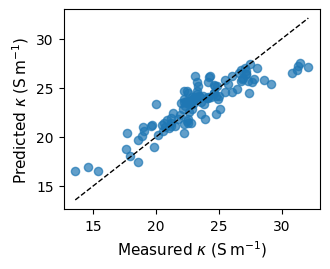

In [81]:
parity_plot(model, X, Y)

# For Camp 2

C:\Users\mrram\AppData\Local\Temp\ipykernel_30080\2766454456.py:128: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_30080\2766454456.py:128: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_30080\2766454456.py:128: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_30080\2766454456.py:128: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Users\mrram\AppData\Local\Temp\ipykernel_30080\2766454456.py:128: DeprecationWarning: Please use `list(space.values())`
  cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
C:\Us

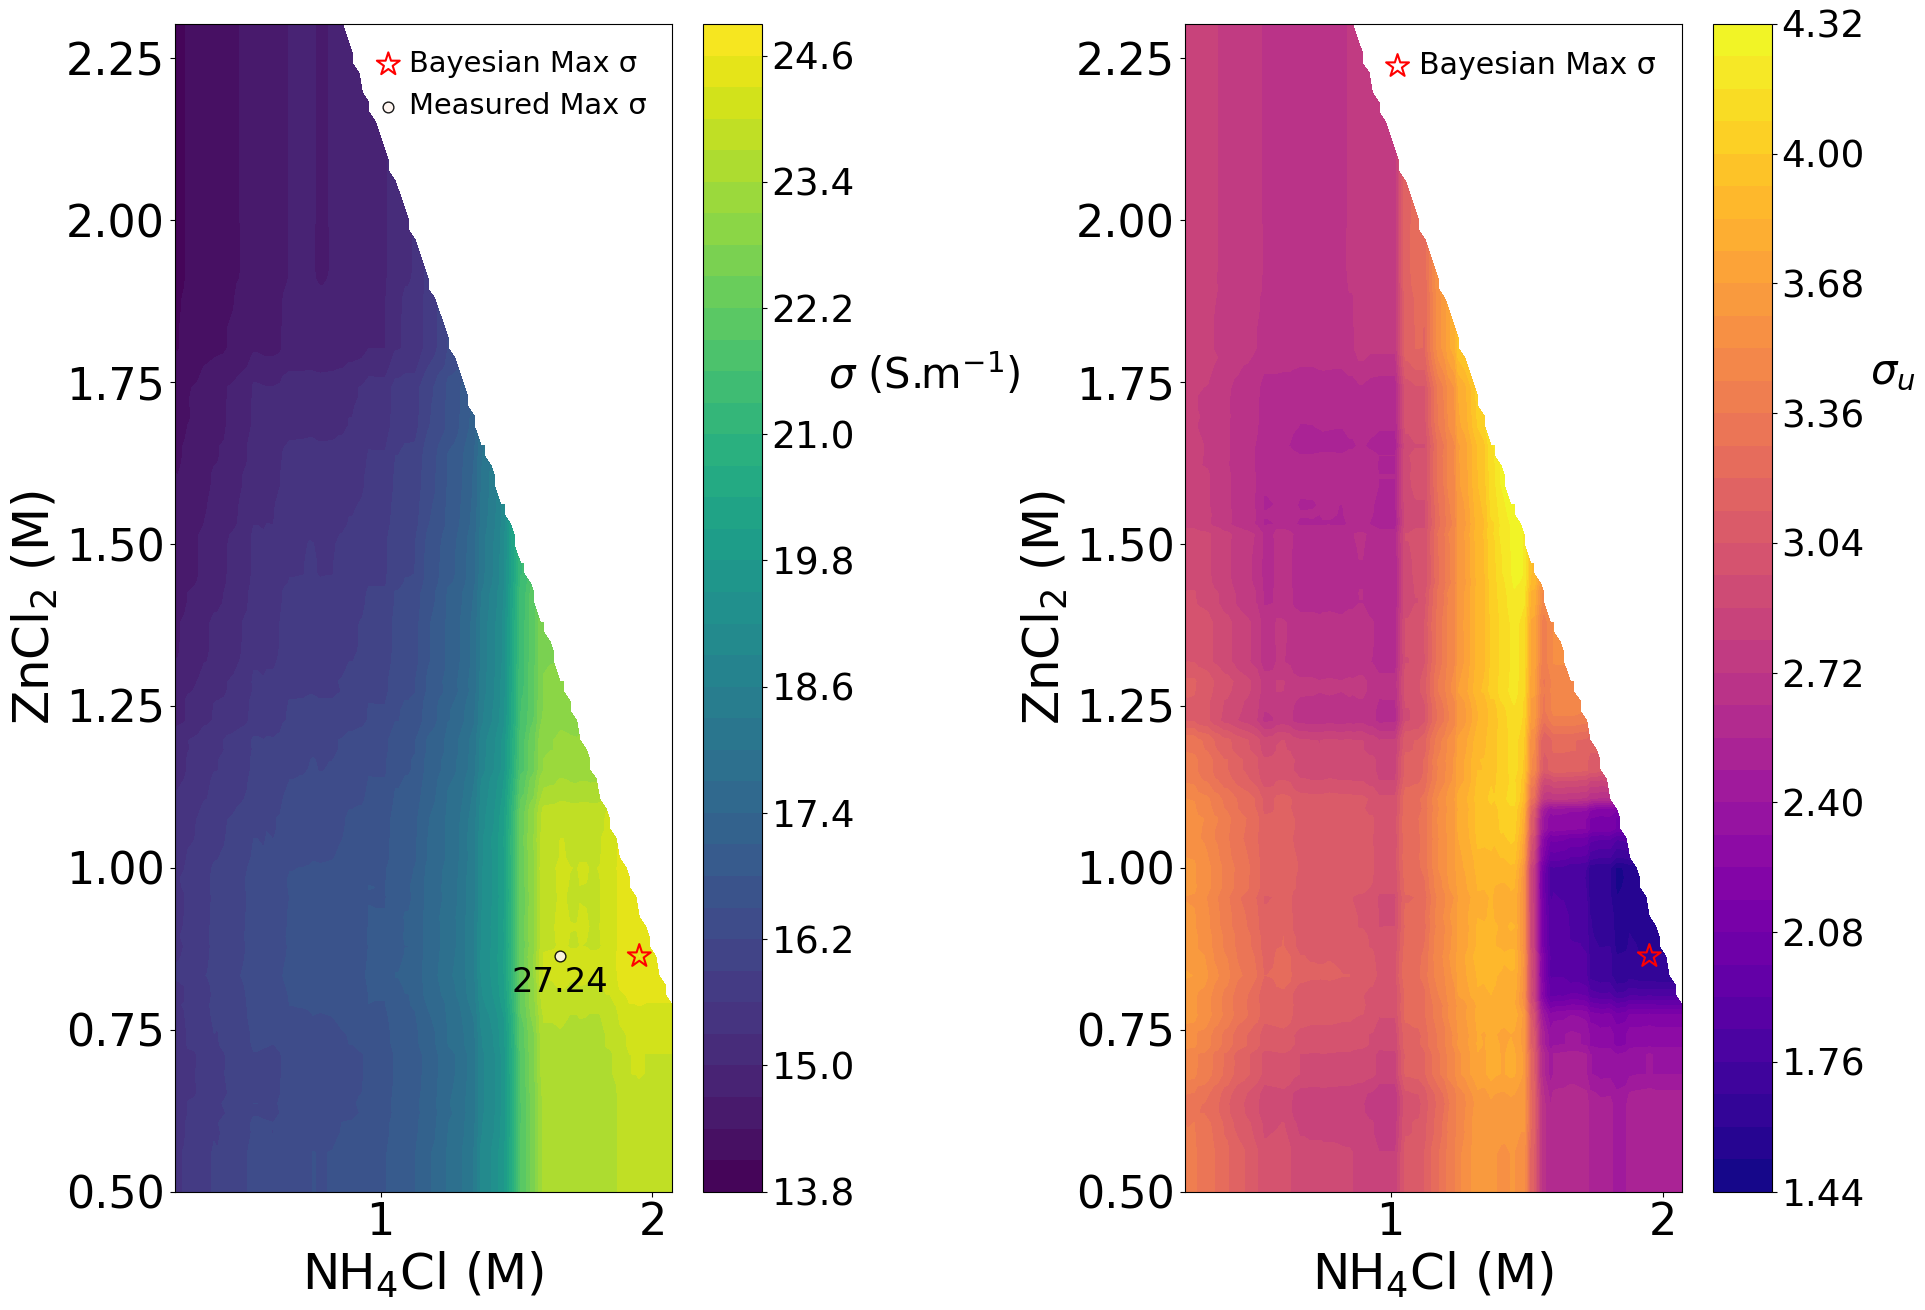

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ConfigSpace import ConfigurationSpace, UniformIntegerHyperparameter, Configuration
from smac import Scenario
from smac.facade.hyperparameter_optimization_facade import HyperparameterOptimizationFacade
from smac.model.random_forest.random_forest import RandomForest
from smac.runhistory.runhistory import RunHistory
from smac.runhistory.enumerations import StatusType

#
# 1-- Build a 5D ConfigSpace exactly as on‐line for Camp2DD:
#    input_1 = ZnCl2  (min=33)
#    input_2 = KCl    (min=20)
#    input_3 = NH4Cl  (min=20)
#    input_4 = NaCl   (min=20)
#    input_5 = EMIMCl (min=20)
#    sum(inputs) ≤ 330
# 
def build_configspace_5salt(num_inputs: int = 5, max_sum: int = 330):
    # NOTE: on‐line code enforced input_1 >= 33 (ZnCl2), others >= 20
    min_vals = [33] + [20] * (num_inputs - 1)
    total_min = sum(min_vals)
    max_vals = [max_sum - (total_min - m) for m in min_vals]

    cs = ConfigurationSpace(seed=42)
    for i in range(num_inputs):
        cs.add(
            UniformIntegerHyperparameter(
                f"input_{i+1}",
                lower = min_vals[i],
                upper = max_vals[i],
            )
        )
    return cs


def csv_to_runhistory_5salt(csv_file: str, cs, obj_col: str = "objective_1", max_sum: int = 330):
    df = pd.read_csv(csv_file).dropna(subset=[obj_col])
    rh = RunHistory()
    for _, row in df.iterrows():
        cfg_vals = {f"input_{i+1}": int(row[f"input_{i+1}"]) for i in range(5)}
        if sum(cfg_vals.values()) > max_sum:
            continue
        cost = -float(row[obj_col])  # SMAC minimise cost = -σ
        rh.add(
            config = Configuration(cs, cfg_vals),
            cost   = cost,
            time   = 0.0,
            status = StatusType.SUCCESS,
            seed   = 0
        )
    return rh

# Train RF
def train_rf_5salt(cs, rh, seed: int = 42):
    X = np.array([cfg.get_array() for cfg in rh.get_configs()])
    Y = np.array([rh.get_cost(cfg) for cfg in rh.get_configs()]).reshape(-1, 1)

    rf = RandomForest(configspace = cs, n_trees = 200, ratio_features = 0.5, log_y = False, seed = seed,)
    rf.train(X, Y)
    return rf, X, Y

# Additional Parity. Won't use it
# def parity_plot_rf(model, X, Y):
#     mu, _ = model.predict_marginalized(X)
#     pred  = -mu.reshape(-1)
#     true  = -Y.reshape(-1)

#     plt.figure(figsize=(3.4, 2.8))
#     plt.scatter(true, pred, alpha=0.7, s=35)
#     lims = (min(true.min(), pred.min()), max(true.max(), pred.max()))
#     plt.plot(lims, lims, "k--", lw=1)
#     plt.xlabel(r"Measured $\sigma$ (S m$^{-1}$)", fontsize=11)
#     plt.ylabel(r"Predicted $\sigma$ (S m$^{-1}$)", fontsize=11)
#     plt.xticks(fontsize=10)
#     plt.yticks(fontsize=10)
#     plt.tight_layout()
#     plt.show()


def slice_2d_5salt(
    model,
    cs,
    fixed,
    axis_x,
    axis_y,
    grid_pts   = 100,
    max_sum    = 330,
    scale_x    = 4.0/330.0,   # scale factor for NH4Cl (input_3)
    scale_y    = 5.0/330.0,    # scale factor for ZnCl2 (input_1)
):
    ticksize   = 32
    labelsize  = 36
    legsize    = 27

    # 5-input labels
    pretty_names = {
        "input_1": "ZnCl$_2$ (M)",
        "input_2": "KCl",
        "input_3": "NH$_4$Cl (M)",
        "input_4": "NaCl",
        "input_5": "EMIMCl"
    }

    # 1 Read CSV to find the observed data‐bounds for axis_x & axis_y
    df_full = pd.read_csv(csv_file)
    x_min_data = int(df_full[axis_x].min())
    x_max_data = int(df_full[axis_x].max())
    y_min_data = int(df_full[axis_y].min())
    y_max_data = int(df_full[axis_y].max())

    # 2 Build grid only over the observed range (integer steps)
    xs = np.linspace(x_min_data, x_max_data, grid_pts, dtype=int)
    ys = np.linspace(y_min_data, y_max_data, grid_pts, dtype=int)

    Z_mu  = np.full((grid_pts, grid_pts), np.nan)
    Z_sig = np.full_like(Z_mu, np.nan)

    # 3 Fill Z_mu, Z_sig by RF‐predict over the 2D grid
    for i, xv in enumerate(xs):
        for j, yv in enumerate(ys):
            # Start from all‐default -> override with fix + sweep
            cfg_dict = {hp.name: hp.default_value for hp in cs.get_hyperparameters()}
            cfg_dict.update(fixed)
            cfg_dict[axis_x] = xv
            cfg_dict[axis_y] = yv

            # If Σ(input) > 330 -> infeasible -> leave NaN
            if sum(cfg_dict.values()) > max_sum:
                continue

            arr = Configuration(cs, cfg_dict).get_array().reshape(1, -1)
            mu, var = model.predict_marginalized(arr)
            Z_mu[j, i]  = -mu.item()
            Z_sig[j, i] = np.sqrt(var.item())

    # 4 Create meshgrid and apply scaling
    Xg, Yg = np.meshgrid(xs, ys)
    Xg_scaled = Xg * scale_x
    Yg_scaled = Yg * scale_y

    # 5 Plot panels
    fig, ax = plt.subplots(1, 2, figsize=(19.2, 13.2))

    # ─── Left panel: σ (μ)
    c1 = ax[0].contourf(
        Xg_scaled, Yg_scaled, Z_mu,
        levels = 40,
        cmap   = "viridis"
    )
    cbar1 = fig.colorbar(c1, ax=ax[0])
    cbar1.set_label(r"$\sigma$ (S.m$^{-1}$)", rotation=0,
                    fontsize=legsize+3, labelpad=50)
    cbar1.ax.tick_params(labelsize=legsize)
    cbar1.ax.yaxis.label.set_position((-0.05, 0.72))

    ax[0].set_xlabel(pretty_names[axis_x], fontsize=labelsize)
    ax[0].set_ylabel(pretty_names[axis_y], fontsize=labelsize)
    ax[0].tick_params(labelsize=ticksize)
    ax[0].set_xlim(x_min_data * scale_x, x_max_data * scale_x)
    ax[0].set_ylim(y_min_data * scale_y, y_max_data * scale_y)

    # Mark μ‐max
    if np.isfinite(Z_mu).any():
        max_idx = np.unravel_index(np.nanargmax(Z_mu), Z_mu.shape)
        x_star  = Xg[max_idx] * scale_x
        y_star  = Yg[max_idx] * scale_y
        ax[0].scatter(
            x_star, y_star,
            s=300, marker='*',
            facecolors='none',
            edgecolors='red',
            linewidths=1.5,
            label = 'Bayesian Max σ'
        )
        ax[0].legend(loc="upper right", fontsize=legsize*0.65, frameon=False)


    slice_df = df_full[
        (df_full["input_2"] == fixed["input_2"]) &   # KCl fixed
        (df_full["input_4"] == fixed["input_4"]) &   # NaCl fixed
        (df_full["input_5"] == fixed["input_5"])     # EMICl fixed
    ]
    
    ax[0].scatter(
        slice_df[axis_x] * scale_x,
        slice_df[axis_y] * scale_y,
        c = slice_df["objective_1"],
        cmap = "Reds",
        edgecolors="black",
        s = 60,
        alpha = 0.9,
        label="Measured Max σ"
    )
    for _, row in slice_df.iterrows():
        ax[0].text(
            row[axis_x] * scale_x,
            row[axis_y] * scale_y - 0.04,
            f"{row['objective_1']:.2f}",
            color='black', fontsize=legsize*0.9,
            ha='center', va='center'
        )
    ax[0].legend(loc="upper right", fontsize=legsize*0.77, frameon=False, handletextpad=-0.3)

    c2 = ax[1].contourf(
        Xg_scaled, Yg_scaled, Z_sig,
        levels = 40,
        cmap   = "plasma"
    )
    cbar2 = fig.colorbar(c2, ax=ax[1])
    cbar2.set_label(r"$\sigma_u$", rotation=0,
                    fontsize=legsize+3, labelpad=20)
    cbar2.ax.yaxis.label.set_position((-0.05, 0.72))
    cbar2.ax.tick_params(labelsize=legsize)

    ax[1].set_xlabel(pretty_names[axis_x], fontsize=labelsize)
    ax[1].set_ylabel(pretty_names[axis_y], fontsize=labelsize)
    ax[1].tick_params(labelsize=ticksize)
    ax[1].set_xlim(x_min_data * scale_x, x_max_data * scale_x)
    ax[1].set_ylim(y_min_data * scale_y, y_max_data * scale_y)

    # μ‐max on σ
    if np.isfinite(Z_mu).any():
        ax[1].scatter(
            x_star, y_star,
            s=300, marker='*',
            facecolors='none',
            edgecolors='red',
            linewidths=1.5,
            label = 'Bayesian Max σ'
        )
        ax[1].legend(loc="upper right", fontsize=legsize*0.8, frameon=False, handletextpad=-0.3)

    plt.tight_layout()
    plt.show()


csv_file = "./candidates_camp2DD.csv"
max_sum = 330
grid_pts = 100

cs = build_configspace_5salt(num_inputs=5, max_sum=max_sum)

rh = csv_to_runhistory_5salt(csv_file, cs, max_sum=max_sum)

model, X, Y = train_rf_5salt(cs, rh)

# parity_plot_rf(model, X, Y)


fix_vals = {
    "input_2": 45,   # KCl
    "input_4": 41,    # NaCl
    "input_5": 21     # EMIMCl
}

axis_x = "input_3"
axis_y = "input_1"

slice_2d_5salt(
    model   = model,
    cs      = cs,
    fixed   = fix_vals,
    axis_x  = axis_x,   # NH4Cl
    axis_y  = axis_y,   # ZnCl2
    grid_pts= grid_pts,
    max_sum = max_sum,
    scale_x = 4.0/330.0,
    scale_y = 5.0/330.0
)


# 3) Error bar

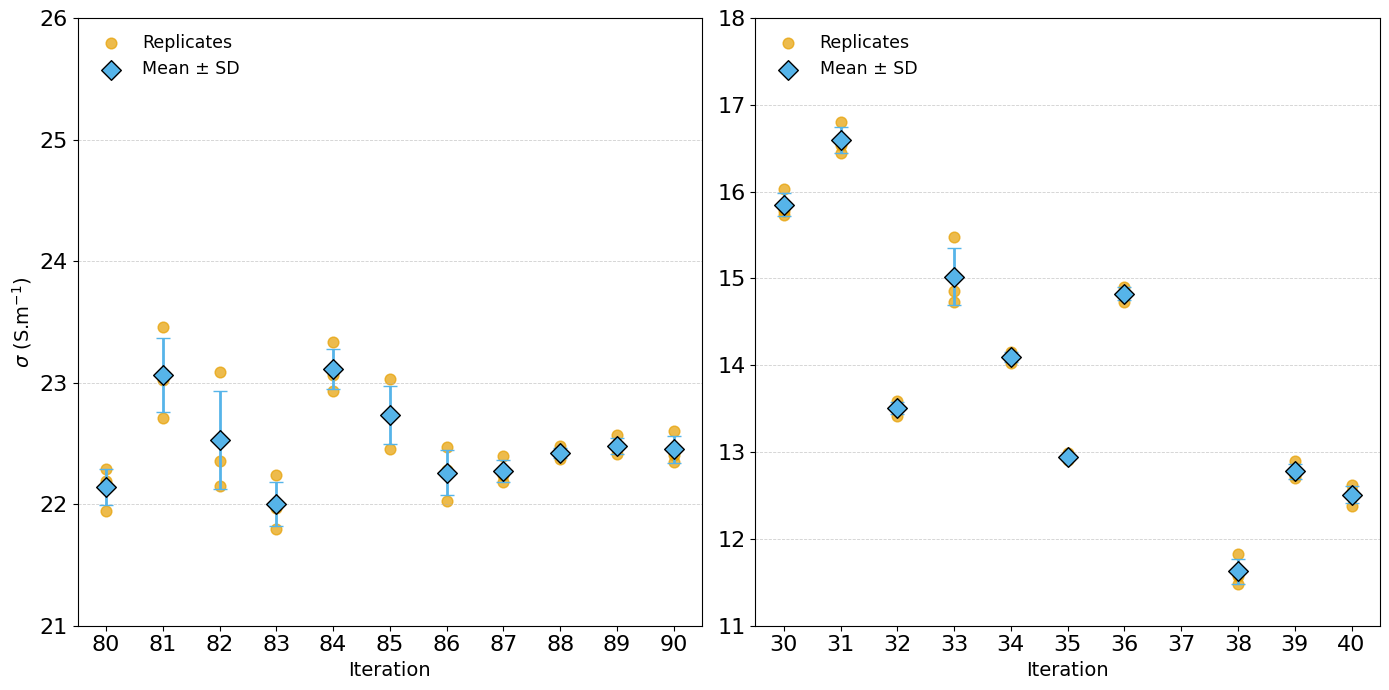

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

R        = 3          # replicates
start1   = 19         # first experiment index
N1       = 11
start2   = 30
N2       = 11

file1    = "./candidates_camp1DD_Full.csv"
file2    = "./candidates_camp2DD_Full.csv"

rep_color  = "#E69F00"
mean_color = "#56B4E9"

fig_w, fig_h       = 14, 7 
fs_labels, fs_ticks, fs_leg = 14, 16, 12.5

# DATA LOADER
def load_experiments(path, R, start, N):
    flat = pd.read_csv(path, header=None).values.flatten()
    if len(flat) % R != 0:
        raise ValueError(f"{path}: rows not a multiple of {R}")
    mat = flat.reshape(-1, R)
    return mat[start-1:start-1+N]

data1 = load_experiments(file1, R, start1, N1)
data2 = load_experiments(file2, R, start2, N2)

# PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_w, fig_h), sharey=False)

# Panel 1: Camp 1
means1 = data1.mean(axis=1)
stds1  = data1.std(axis=1)
rstart1 = start1 + 61
xs1    = np.arange(rstart1, rstart1 + N1)


# replicates
for i, xi in enumerate(xs1):
    ax1.scatter(
        np.full(R, xi),
        data1[i],
        color=rep_color,
        s=60,
        alpha=0.7,
        marker='o',
        label="Replicates" if i == 0 else None
    )

# mean ± SD
ax1.scatter(
    xs1, means1,
    color=mean_color,
    s=100,
    marker='D',
    edgecolor='black',
    label="Mean ± SD",
    zorder=3
)
ax1.errorbar(
    xs1, means1,
    yerr=stds1,
    fmt='none',
    ecolor=mean_color,
    elinewidth=2,
    capsize=5,
    zorder=2
)

ax1.set_xlabel("Iteration", fontsize=fs_labels)
ax1.set_xlim(rstart1 - 0.5, rstart1 + N1 - 0.5)
ax1.set_xticks(xs1)
ax1.set_xticks(xs1)
ax1.tick_params(axis="both", labelsize=fs_ticks)
ax1.set_ylabel(r"$\sigma$ (S.m$^{-1}$)", fontsize=fs_labels)
ax1.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
ax1.legend(fontsize=fs_leg, frameon=False, loc="upper left")
ax1.set_ylim(21, 26)

# Panel 2 = Camp2
means2 = data2.mean(axis=1)
stds2  = data2.std(axis=1)
xs2    = np.arange(start2, start2 + N2)

for i, xi in enumerate(xs2):
    ax2.scatter(
        np.full(R, xi),
        data2[i],
        color=rep_color,
        s=60,
        alpha=0.7,
        marker='o',
        label="Replicates" if i == 0 else None
    )

ax2.scatter(
    xs2, means2,
    color=mean_color,
    s=100,
    marker='D',
    edgecolor='black',
    label="Mean ± SD",
    zorder=3
)
ax2.errorbar(
    xs2, means2,
    yerr=stds2,
    fmt='none',
    ecolor=mean_color,
    elinewidth=2,
    capsize=5,
    zorder=2
)

ax2.set_xlabel("Iteration", fontsize=fs_labels)
ax2.set_xlim(start2 - 0.5, start2 + N2 - 0.5)
ax2.set_xticks(xs2)
ax2.tick_params(axis="x", labelsize=fs_ticks)
ax2.tick_params(axis="y", labelsize=fs_ticks)
ax2.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
ax2.legend(fontsize=fs_leg, frameon=False, loc="upper left")
ax2.set_ylim(11, 18)

plt.tight_layout()
plt.show()
